* lmohim Le lien dial kaggle li knt sayft likom fih dataset w ila 9lbto f code section ghatl9aw nas li déjà khdmo b dak dataset w daro some projects, ana jrbt l code lwl li tl3 lia and it works just fine , lmohim mn more ma t2kdt bli model khdam mzn , fine tunito 3la 3 classes safi w savit l model w khdmt b open cv bach input ykouno video frames instead of images w sf , w hakda hadchi khdm . 

* lmohim hada dar b pytorch, ila bghito tkhdmo b pytorch wla tensorflow daba wla in cha2a lah mn b3d f des projets fa ra nfs les étapes li f had code ki daro ta9riban f kolchi avec quelques diff 3la 7sab l probleme mais nfs les grandes étapes li kat 3rfo ki b9aw: data processing, training , validation , testing w moraha savi l model + mzn t3lmo les deux frameworks 7it kola w7da t9dr tfidk 3la 7sab data dialk w chno bghiti.

* bzaf dial les étapes hnaya daro ghir hit khdamin b torch , I mean tensorflow simple 3la torch bzf. b7al device management w 7ta data format...


# 1) Awal haja khas ndiroha hia n importiw ga3 packages or modules li ghan7tajohom wla n9dro n7tajohom hhh

In [ ]:
import os
import torch
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F



from modelArchitecture import ResNet

from dataset.data_prepation import dataset, transformations

from device.Device import get_default_device, to_device, DeviceDataLoader

['cardboard', 'clothes', 'plastic']
Number of images in the 'clothes' directory: 797
Total images in the dataset: 2553


# 2) Tani haja khasna ndiroha hia n 9ado data dialna , n9smoha l train , test, val w n9adoha f l format li torch li ki khdm biha

In [5]:
random_seed = 42
torch.manual_seed(random_seed)

In [6]:
print(f"Total images in the dataset: {len(dataset)}")

Total images in the dataset: 2553


In [7]:
train_ds, val_ds, test_ds = random_split(dataset, [1500, 300, 753])
len(train_ds), len(val_ds), len(test_ds)

(1500, 300, 753)

In [8]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32

In [9]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)

# 3) daba ja lw9t fin n instancyin l AI model dialna li howa resnet w ghanakhdoh mn module "modelArchitecture" w ghaykoun déjà pretrained w hadchi 7it 3ndna data 9lila donc maymknch ntrainiw b model from scratch dakchi lach ghir ghandi n fine tuniw resnet 

In [12]:
model = ResNet()

c:\Users\moham\Dokument\Club\Formation\Smart_Bin\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\moham\Dokument\Club\Formation\Smart_Bin\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
device = get_default_device()
device


device(type='cpu')

In [14]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

# 4) daba la pahse dial training w validation dial model , ghadi n evaluéw 9bl kifach lmodel khdam 9bl training w mora training nchoufo

In [15]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [16]:
model = to_device(ResNet(), device)

In [17]:
evaluate(model, val_dl)


{'val_loss': 1.100841760635376, 'val_acc': 0.35085228085517883}

In [18]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 5.5e-5

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch 1: train_loss: 0.7057, val_loss: 0.5709, val_acc: 0.9906
Epoch 2: train_loss: 0.5682, val_loss: 0.5683, val_acc: 0.9906
Epoch 3: train_loss: 0.5637, val_loss: 0.5639, val_acc: 0.9923
Epoch 4: train_loss: 0.5559, val_loss: 0.5603, val_acc: 0.9923
Epoch 5: train_loss: 0.5555, val_loss: 0.5627, val_acc: 0.9937
Epoch 6: train_loss: 0.5579, val_loss: 0.5612, val_acc: 0.9937
Epoch 7: train_loss: 0.5553, val_loss: 0.5635, val_acc: 0.9892
Epoch 8: train_loss: 0.5547, val_loss: 0.5682, val_acc: 0.9830
Epoch 9: train_loss: 0.5540, val_loss: 0.5637, val_acc: 0.9906
Epoch 10: train_loss: 0.5538, val_loss: 0.5644, val_acc: 0.9906


# 5) hado some plots dial kifach acc kant f chaque epoch, w 7ta loss

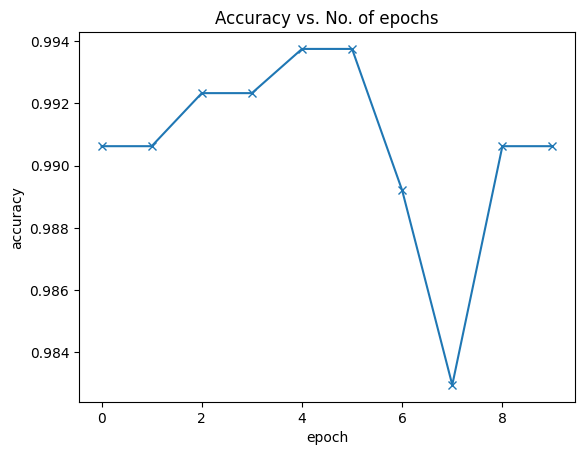

In [19]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

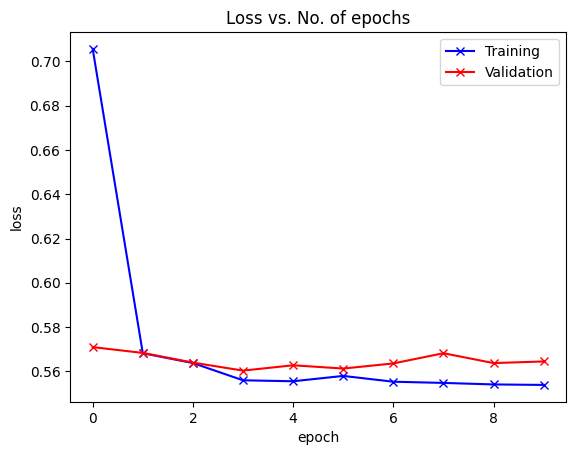

In [20]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

# 6) hna ghir ghantestiw l model dialna 3la tsawr jdad 

In [21]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: cardboard , Predicted: cardboard


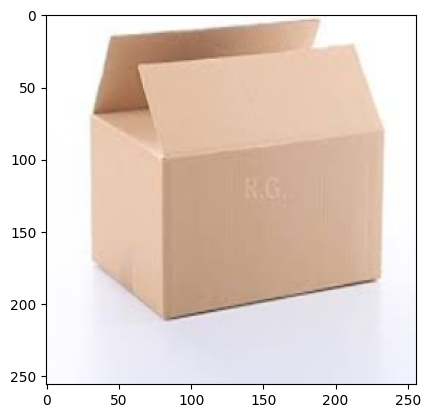

In [22]:
img, label = test_ds[17]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: plastic , Predicted: plastic


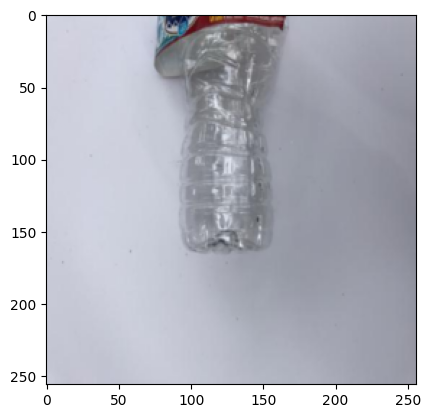

In [23]:
img, label = test_ds[12]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: clothes , Predicted: clothes


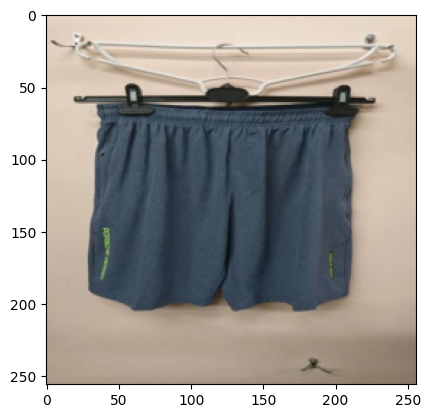

In [24]:
img, label = test_ds[51]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

# 7) daba khas nsaviw model or model parameters bach n9dro n integriwh fl projet dialna 

In [25]:
loaded_model = model


In [26]:
torch.save(loaded_model.state_dict(), 'modelparam.pth')
print("Model saved successfully!")

Model saved successfully!


In [27]:
torch.save(loaded_model, 'wholemodel.pth')
print("Model saved successfully!")

Model saved successfully!
